## Light Curve Analysis Module

**Lecturer:** Melissa Hayes-Gehrke<br>
**Jupyter Notebook Authors:** Melissa Hayes-Gehrke & Cameron Hummels

This is a Jupyter notebook lesson taken from the GROWTH Summer School 2020.  For other lessons and their accompanying lectures, please see: http://growth.caltech.edu/growth-school-2020.html

## Objective
Identify periodic behavior in noisy observational data to generate light curves

## Key steps
- Extract a periodic signal from noisy data when we know the period of the oscillation
- Use the Lomb Scargle algorithm to extract a light curve from data when we do not know the period
- Apply the Lomb Scargle to real Cepheid observational data

## Required dependencies

See GROWTH school webpage for detailed instructions on how to install these modules and packages.  Nominally, you should be able to install the python modules with `pip install <module>`.  The external astromatic packages are easiest installed using package managers (e.g., `rpm`, `apt-get`).

### Python modules
* python 3
* astropy
* numpy
* matplotlib

### External packages
None

In [3]:
import numpy as np
from astropy.timeseries import LombScargle
%matplotlib inline
import matplotlib.pyplot as plt
import os

In [4]:
cwd = os.getcwd()
data_dir = os.path.join(cwd, 'data')

Generate a Synthetic Lightcurve

First, we need to generate a lightcurve to work with. The function below generates a series of timestamps t, and a sinusoidal signal y with noise dy added to it. We will use this lightcurve to test our functions. Note that our y values are generated with a sin function with a frequency of 2pi, or equiaveletly, a period of 1.

Text(0, 0.5, 'Flux')

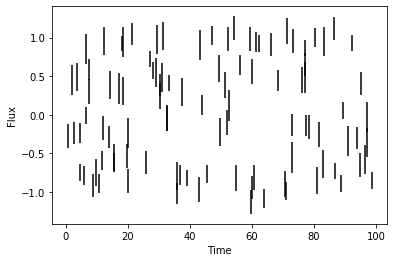

In [5]:
# "Generates a sample lightcurve with times t, magnitudes y, and errors dy

rand = np.random.RandomState(42)
t = 100 * rand.rand(100)
y = np.sin(2 * np.pi * t) + 0.1 * rand.randn(100)
dy = 0.1 * (1 + rand.rand(100))

plt.errorbar(t,y,dy,ls='none',c='k')
plt.xlabel('Time')
plt.ylabel('Flux')


As you can see, this lightcurve is not very interesting when we plot it. This is where we need to use period finding analysis to learn more. Below, we try plotting the function in a new way--phase folding it. When we do this, we assume a period, and compute what phase each timestamps corresponds to between 0 and 1, assuming that period. Below, we try folding our lightcurve with the period equal to 1.

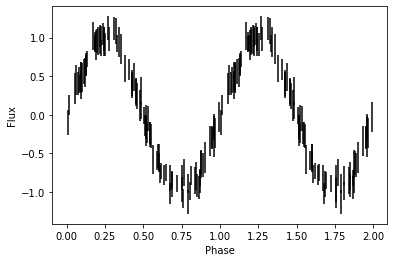

In [6]:
rand = np.random.RandomState(42)
t = 100 * rand.rand(100)
y = np.sin(2 * np.pi * t) + 0.1 * rand.randn(100)
dy = 0.1 * (1 + rand.rand(100))



# "this function takes times t, mags y, and errors dy, and a period and phase folds the lightcurve at this period

def phase_fold(t,y,dy,period):
    phases=np.remainder(t,period)/period
    phases=np.concatenate((phases,phases+1))
    y=np.concatenate((y,y))
    dy=np.concatenate((dy,dy))
    plt.errorbar(phases,y,dy,ls='none',c='k')
    plt.xlabel('Phase')
    plt.ylabel('Flux')
    
phase_fold(t,y,dy,1)


Phase-folding can be used as a rudimentary method of period determination.  One may make educated guesses about the period of the phenomenon and phase-fold the lightcurve to see if a repeating pattern emerges.  Try this for this observations of the asteroid 1856 Ruzena, observed by non-Astronomy majors from the University of Maryland in April 2018 along with collaborators in Malta.  Asteroids typically have rotation periods between 2 and 12 hours.

The code below plots the raw, or unphased lightcurve, for all four nights of observations of the asteroid.

Text(0, 0.5, 'Differential Magnitude')

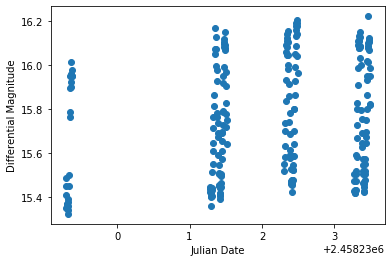

In [7]:
data=np.loadtxt(os.path.join(data_dir,'asteroid1.csv'),delimiter=',',skiprows=1)
t=data[:,0]
y=data[:,1]
plt.plot(t,y,ls='none',marker="o")
plt.xlabel('Julian Date')
plt.ylabel('Differential Magnitude')


Why does the plot above show four vertical strings of points?  Each vertical "string" of points is one night of observations.  Compared to the entire period of time along the x-axis, each night is a very small length of time.  If you alter the code in the cell and change the limits on the x axis, you, can view each night of data individually.  (This will help you get an idea of the length of the asteroid's rotation period, so this is an especially useful exercise.)

It's not unusual for astronomers to have large gaps in lightcurves due to daytime and longer periods of time when observations were not able to be made (i.e., weather, length of observing cycles).  Phase-folding, or phasing, the lightcurve to trial periods allows one to remove these gaps and visualize the data more easily.

Below, you will try phasing the data for 1856 Ruzena to trial periods to see if you can determine the asteroid's rotation period by the trial-and error method.  Don't spend more than 5 minutes trying different test periods - you could do this all day and never get lucky with the correct period, since you'll need several decimal places of precision.  (The students from the class published the rotation periods to 4 decimal places of precision using only these data.)

Also, consider carefully:  when you have correctly determined the asteroid's rotation period and have a phased lightcurve, how many maxima and minima should it have in one complete phase?

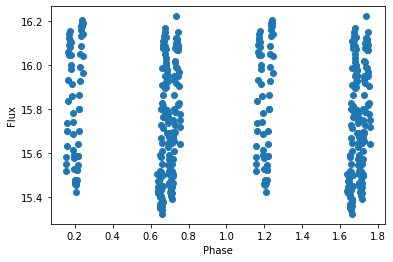

In [8]:
data=np.loadtxt(os.path.join(data_dir,'asteroid1.csv'),delimiter=',',skiprows=1)
t=data[:,0]
y=data[:,1]
period=2
#period in units of days

def phase_fold(t,y,period):
    phases=np.remainder(t,period)/period
    phases=np.concatenate((phases,phases+1))
    y=np.concatenate((y,y))
    plt.plot(phases,y,ls='none',marker="o")
    plt.xlabel('Phase')
    plt.ylabel('Flux')
    
phase_fold(t,y,period)

From your experience with the trial-and-error method above, you can see that a better method of finding test periods is needed.  This is where the Lomb-Scargle Periodogram method is used.  This method essentially measures how much power is present at each frequency within the data: more power at a certain frequency should indicate a repeating signal within the data.  However, that signal could be from a physical phenomenon, such as a pulsating star or rotating asteroid, or it could be an artifact, such as the day/night cycle or other artificial frequencies caused by the observing process.  The astronomer must interpret the data to make a final decision.

The code below applies the Lomb-Scargle Periodogram to the synthetic sine curve constructed at the beginning of this notebook.  In this case, we know that the period is 1 day; usually one does not know this ahead of time, and so we will use the LS Periodogram to tell us this.

The function below returns the best period and the power spectrum (which shows us the relative strength of signals at different frequencies (frequency = 1/period).  You should see a large spike at period = 1.  Try changing the value of the period and watch the periodogram (the power spectrum graph) change.

1.0003718852975687

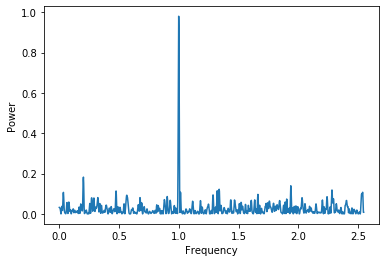

In [9]:
period=1


rand = np.random.RandomState(42)
t = 100 * rand.rand(100)
y = np.sin(2 * np.pi /period* t) + 0.1 * rand.randn(100)
dy = 0.1 * (1 + rand.rand(100))

def lomb_scargle(t,y,dy):

    frequency, power = LombScargle(t, y, dy).autopower()
    plt.plot(frequency, power)
    plt.show
    plt.xlabel('Frequency')
    plt.ylabel('Power')
    return 1/frequency[np.argmax(power)]
lomb_scargle(t,y,dy)

We use the frequency with the most power to find the best period to represent the signal in the data.  In the code below, we put the LS algorithm together with the phase-folding code to plot the phase-folded data with the best period.

In [ ]:
period=1

rand = np.random.RandomState(42)
t = 100 * rand.rand(100)
y = np.sin(2 * np.pi /period* t) + 0.1 * rand.randn(100)
dy = 0.1 * (1 + rand.rand(100))

def lomb_scargle(t,y,dy):

    frequency, power = LombScargle(t, y, dy).autopower()
    return 1/frequency[np.argmax(power)]

def plot_best_period(t,y,dy):
    phase_fold(t,y,lomb_scargle(t,y,dy))
    
    print(period)

plot_best_period(t,y,dy)

Let us apply the Lomb-Scargle Periodogram to real data.  First, let's take a look at unphased Cepheid data using the code below. (These data are from the American Association of Variable Star Observers.)   Please complete the code block below to plot the unphased data. Notice how these data span a very long time period.  You may alter the code block in order to examine shorter time periods.  Do you have an educated guess about the period of this Cepheid?

In [ ]:
data=np.loadtxt(os.path.join(data_dir,'cepheid.csv'),delimiter=',',skiprows=1)
t=data[:,0]
y=data[:,1]
#complete plotting the raw lightcurve; please check data file to label axes appropriately

Now we apply the LS algorithm to the Cepheid data.  

In [ ]:
data=np.loadtxt(os.path.join(data_dir,'cepheid.csv'),delimiter=',',skiprows=1)
t=data[:,0]
y=data[:,1]
#uncomment code below to continue
#def lomb_scargle(t,y):

 #   frequency, power = LombScargle(t, y).autopower()
 #  return 1/frequency[np.argmax(power)]

#def phase_fold(t,y,period):
#    phases=np.remainder(t,period)/period
#    phases=np.concatenate((phases,phases+1))
#    y=np.concatenate((y,y))
#    plt.scatter(phases,y,c='k')
#    plt.xlabel('Phase')
#    plt.ylabel('Flux')
#    print(period)

#def plot_best_period(t,y):
#    phase_fold(t,y,lomb_scargle(t,y))

#plot_best_period(t,y)

Now, let's apply the LS algorithm to the 1856 Ruzena data in order to see which frequencies the algorithm says have the most power.  This should tell us the rotation period of the asteroid.   Please complete the code in the block below in order to plot the periodogram for the 1856 Ruzena data.  It would be most useful in interpreting the periodogram if the "best" period was outputted in hours, since astronomers are used to discussing asteroid rotation period in hours.

Once you get the outputted best period (in hours), when you put it into the phase-folding code that we used for the asteroid above, does it yield a good phased lightcurve for the asteroid?  BE CAREFUL HERE:  should an asteroid's lightcurve have one or two maxima (and minima) per rotation?  And does the LS algorithm output take that into account?  Human interpretation is always necessary in science.

In [ ]:
data=np.loadtxt(os.path.join(data_dir,'asteroid1.csv'),delimiter=',',skiprows=1)
t=data[:,0]
y=data[:,1]

#complete the Lomb-Scargle code for the asteroid data

Challenge:  The above data sets were relatively straightfoward to work with using the Lomb-Scargle Periodogram because the data were rather "clean" and did not exhibit much power at alternative frequencies.  You can find two additional data sets in the data director for this module.  One is "asteroid2", which is for the asteroid 4404 Enirac observed by student at the University of Maryland in Spring 2017.  The other is "delta-scuti", which is for a Delta Scuti-type variable star.  You will find that both of these objects have very "messy" periodograms, in which is its unclear what the "best" period is.  You can attack each of these objects by lookig at subsets of the data (and running LS on the subsets), potentially temporarily eliminating data points which are outliers, and otherwise being clever in your analysis  You can begin your analysis in the space below.

You can also download your own data for many variable objects from the American Association of Variable Star Observers' website, aavso.org.